In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [15]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=e9058ac139d11dd501fa421cffe549714cc774642661738c6ab368bda92b5386
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [16]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from datetime import datetime
import wandb
import argparse

In [17]:
class TitanicDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)    # X(feature vector) : float32
        self.y = torch.LongTensor(y)     # y(target) : int64

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        feature = self.X[idx]
        target = self.y[idx]
        return {'input': feature, 'target': target}

    def __str__(self):
        return f"Data Size: {len(self.X)}, Input Shape: {self.X.shape}, Target Shape: {self.y.shape}"

In [18]:
class TitanicTestDataset(Dataset):
    def __init__(self, X):
        self.X = torch.FloatTensor(X)    # X(feature vector) : float32

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        feature = self.X[idx]
        return {'input': feature}

    def __str__(self):
        return f"Data Size: {len(self.X)}, Input Shape: {self.X.shape}"

In [21]:
def get_preprocessed_dataset():
    # CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
    # CURRENT_FILE_PATH = "C:/Users/ChoKW/git/CSE533/Assignment/hw2/data"
    CURRENT_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks"

    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    train_df = pd.read_csv(train_data_path) # get train csv file from path
    test_df = pd.read_csv(test_data_path)   # get test csv file from path

    all_df = pd.concat([train_df, test_df], sort=False) # combine two datasets which shape are same

    all_df = get_preprocessed_dataset_1(all_df) # To make sure dataset does not contain any null value in "Fare"

    all_df = get_preprocessed_dataset_2(all_df) # Split Full name into family_name, honorific and name

    all_df = get_preprocessed_dataset_3(all_df) # To make sure dataset does not contain any null value in "Age"

    all_df = get_preprocessed_dataset_4(all_df)

    all_df = get_preprocessed_dataset_5(all_df)

    all_df = get_preprocessed_dataset_6(all_df)

    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    dataset = TitanicDataset(train_X.values, train_y.values)    # create dataset
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])   # split data into train, validation
    test_dataset = TitanicTestDataset(test_X.values)

    return train_dataset, validation_dataset, test_dataset


In [3]:
def get_preprocessed_dataset_1(all_df):
    # get mean for each Pclass
    # result
    #     Pclass       Fare
    # 0       1  87.508992
    # 1       2  21.179196
    # 2       3  13.302889
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    # name the columns
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    # merge all_df and Fare_mean with "Pclass", based on all_df's "Pclass"
    # if all_df's Pclass == 1, it's Fare_mean will be 87.508992
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    # if all_df's Fare is null, change it into Fare_mean value
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]

    return all_df


In [4]:
def get_preprocessed_dataset_2(all_df):
    # split name into family name, honorific, name
    # max split = n = 2, if to make a list, expand = False, if to expand dimesion, expand = True
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "honorific", "name"]
    # remove leading and trailing characters
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    # combine two dfs
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df

In [5]:
def get_preprocessed_dataset_3(all_df):
    # get medium Age value of each honorific, then round it
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    # set column name
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]
    # merge all_df and honorific_age_mean with "Honorific", based on all_df's "Honorific"
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    # if all_df's Age is null, change it into honorific_age_mean value
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    # label remove
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    return all_df

In [6]:
def get_preprocessed_dataset_4(all_df):
    # add family_num column
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # add alone column
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0, inplace=True)

    # remove unused data from all_df
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df

In [7]:
def get_preprocessed_dataset_5(all_df):
    # decrease number of honorific
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),
    "honorific"
    ] = "other" # set honorific as Mr, Miss, Mrs, Master and other
    all_df["Embarked"].fillna("missing", inplace=True)

    return all_df

In [8]:
def get_preprocessed_dataset_6(all_df):
    # data types == "object"
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()
        # encode category_feature
        if all_df[category_feature].dtypes == "object":
            le = le.fit(all_df[category_feature])
            # transform labels to normalized encoding
            all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df


In [9]:
from torch import nn, optim

class MyModel(nn.Module):    # create my model
    def __init__(self, n_input, n_output):
        super().__init__()

        self.model = nn.Sequential(    # use 5 layer
            nn.Linear(n_input, 30),     # shape : [n_input, 30]
            nn.ReLU(),
            nn.Linear(30, 30),          # shape : [30, 30]
            nn.ReLU(),
            nn.Linear(30, n_output),    # shape : [30, n_output]
        )

    def forward(self, x):   # return result
        x = self.model(x)
        return x

In [10]:
def test(test_data_loader):
    # test the model
    print("[TEST]")
    batch = next(iter(test_data_loader))
    print(f"{batch['input'].shape}")
    model = MyModel(n_input=11, n_output=2)
    output_batch = model(batch['input'])
    prediction_batch = torch.argmax(output_batch, dim=1)
    for idx, prediction in enumerate(prediction_batch, start=892):
        print(idx, prediction.item())

In [11]:
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
    n_epochs = wandb.config.epochs
    loss_fn = nn.CrossEntropyLoss()
    next_print_epoch = 100

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        num_trains = 0
        for train_batch in train_data_loader:
            output_train = model(train_batch['input'])
            loss = loss_fn(output_train, train_batch['target'])
            loss_train += loss.item()
            num_trains += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_validation = 0.0
        num_validations = 0
        with torch.no_grad():
            for validation_batch in validation_data_loader:
                output_validation = model(validation_batch['input'])
                loss = loss_fn(output_validation, validation_batch['target'])
                loss_validation += loss.item()
                num_validations += 1

        wandb.log({
        "Epoch": epoch,
        "Training loss": loss_train / num_trains,
        "Validation loss": loss_validation / num_validations
        })

        if epoch >= next_print_epoch:
            print(
                f"Epoch {epoch}, "
                f"Training loss {loss_train / num_trains:.4f}, "
                f"Validation loss {loss_validation / num_validations:.4f}"
            )
            next_print_epoch += 100

In [31]:
def train(train_data_loader, validation_data_loader):
    model = MyModel(n_input=11, n_output=2)
    optimizer = optim.SGD(model.parameters(), lr=wandb.config.learning_rate)

    wandb.watch(model)

    training_loop(
        model=model,
        optimizer=optimizer,
        train_data_loader=train_data_loader,
        validation_data_loader=validation_data_loader
    )

    wandb.finish()

    torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/model.pth")
    # torch.save(model.state_dict(), "C:/Users/ChoKW/git/CSE533/Assignment/hw2/model")

In [32]:
def predict(test_data_loader):
    model = MyModel(n_input=11, n_output=2)
    model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/model/model.pth'))
    # model.load_state_dict(torch.load('C:/Users/ChoKW/git/CSE533/Assignment/hw2/model'))
    model.eval()

    predictions = []
    for batch in test_data_loader:
        input = batch['input']
        output = model(input)
        predictions_batch = torch.argmax(output, dim=1)
        predictions.extend(predictions_batch.tolist())

    submission_df = pd.DataFrame({
        "PassengerId": range(892, 892 + len(predictions)),
        "Survived": predictions
    })

    submission_df.to_csv('/content/drive/MyDrive/Colab Notebooks/submission.csv', index=False)

In [24]:
!wandb login 5963d7f1fe643c37d53ab69f1dace10fa3ce44fc

In [33]:
if __name__ == "__main__":
    train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

    print(f"train_dataset: {len(train_dataset)}, validation_dataset.shape: {len(validation_dataset)}, test_dataset: {len(test_dataset)}")
    print("#" * 50, 1)

    for idx, sample in enumerate(train_dataset):
        print(f"{idx} - {sample['input']}: {sample['target']}")

    print("#" * 50 , 2)

    train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=True)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

    print("[TRAIN]")
    for idx, batch in enumerate(train_data_loader):
        print(f"{0} - {batch['input'].shape}: {batch['target']}")

    for idx, batch in enumerate(validation_data_loader):
        print(f"{0} - {batch['input'].shape}: {batch['target']}")

    print("#" * 50, 3)

    test(test_data_loader)

    #########################################
    current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        "epochs": 1_000,
        "batch_size": 512,
        "learning_rate": 1e-3,
    }

    wandb.init(
        mode="online",
        project="hw2",
        name=current_time_str,
        config=config
    )

    train(train_data_loader, validation_data_loader)
    predict(test_data_loader)

train_dataset: 713, validation_dataset.shape: 178, test_dataset: 418
################################################## 1
0 - tensor([ 3.0000,  1.0000, 25.0000,  1.0000,  0.0000,  7.7750,  2.0000, 13.3029,
         2.0000,  1.0000,  0.0000]): 0
1 - tensor([ 3.0000,  0.0000, 22.0000,  0.0000,  0.0000,  7.7500,  2.0000, 13.3029,
         1.0000,  0.0000,  1.0000]): 1
2 - tensor([ 3.0000,  1.0000,  3.0000,  1.0000,  1.0000, 15.9000,  2.0000, 13.3029,
         0.0000,  2.0000,  0.0000]): 1
3 - tensor([ 3.0000,  1.0000, 29.0000,  0.0000,  0.0000,  9.5000,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
4 - tensor([ 3.0000,  1.0000, 28.0000,  0.0000,  0.0000,  7.7958,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
5 - tensor([ 2.0000,  0.0000, 42.0000,  1.0000,  0.0000, 26.0000,  2.0000, 21.1792,
         3.0000,  1.0000,  0.0000]): 1
6 - tensor([ 3.0000,  1.0000, 19.0000,  0.0000,  0.0000,  0.0000,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
7 - tensor([ 1.00

Epoch 100, Training loss 0.5729, Validation loss 0.5481
Epoch 200, Training loss 0.5541, Validation loss 0.5168
Epoch 300, Training loss 0.5155, Validation loss 0.4917
Epoch 400, Training loss 0.4796, Validation loss 0.5565
Epoch 500, Training loss 0.4599, Validation loss 0.5669
Epoch 600, Training loss 0.4385, Validation loss 0.4615
Epoch 700, Training loss 0.4258, Validation loss 0.6384
Epoch 800, Training loss 0.4365, Validation loss 0.6145
Epoch 900, Training loss 0.4277, Validation loss 0.5386
Epoch 1000, Training loss 0.4098, Validation loss 0.5114


Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training loss,██▇▇▇▇▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▁▂▁▂▁▁▂▁▂▁
Validation loss,▇▄▄▅▃▄▅▅▄▅▃▆▄▆▂▃▆▆▂▃▃▃▃▂▄▃▁▁▇▁▂█▂▂▄▅▂▆▄▂
Epoch,1000
Training loss,0.40979
Validation loss,0.51136


## 취득한 기술적 사항/고찰 내용

  - 데이터 전처리에 대해 좀 더 자세히 알게 되었다.
  - 텐서를 통해 데이터를 내 입맛대로 다루는 방법을 알게 되었다.
  - 데이터가 주어졌을 때, 이것을 그대로 사용하는 것도 좋지만, 나만의 방법으로 좀 더 세분화해서 나타낼 수 있는 방법을 알게 되었다.
  - wandb는 transformers가 자동제공하는 것만 써보았는데, 이번엔 직접 wandb를 초기화하고, 연결하고, 로그를 저장하는 것 등을 해봄으로써 wandb에 대해 더 자세히 알게 되었다.
  - 마찬가지로, training도 Trainer 클래스가 자동 제공하는 학습만 사용해보았는데, 직접 모델을 구성하고, 그 모델을 통해 학습을 시킴으로써 더 자세히 알게 되었다.

## 숙제 후기
  - 정말 좋은 과제이다. 모델학습에서 제일 중요한건 얼마나 순도있는 데이터로 학습시키냐인데, 이것을 가장 기초에서부터 잘 알려주는 과제인 것 같다.
  - 데이터를 잘 다루는 사람이 더 좋은 모델을 개발할텐데, 내게 더 좋은 모델을 개발해주는 길을 열어주는 것 같았다.

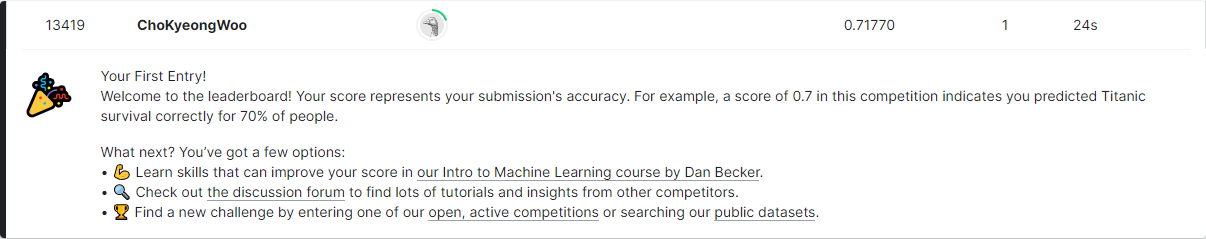